## Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier (normalize your features and randomize a selection for training and testing)

* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [1]:
# import the necessiary modules
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

In [2]:
# Load training images
car_images = glob.glob('vehicles/**/*.png')
noncar_images = glob.glob('non-vehicles/**/*.png')
print(len(car_images), len(noncar_images))

8792 8968


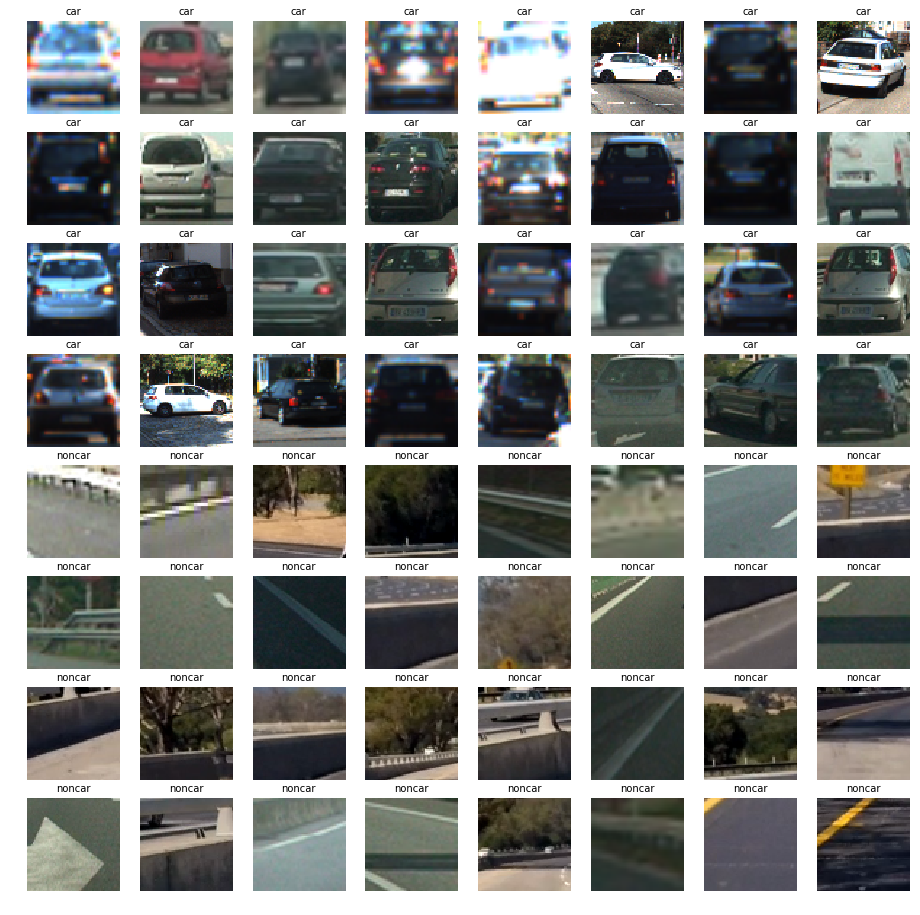

In [3]:
#Display some of the images from the training set
fig, axs = plt.subplots(8,8, figsize=(16,16))
fig.subplots_adjust(hspace = 0.2, wspace=.1)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i in np.arange(32):
    img = cv2.imread(car_images[np.random.randint(0,len(car_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('car', fontsize=10)
    axs[i].imshow(img)
for i in np.arange(32,64):
    img = cv2.imread(noncar_images[np.random.randint(0,len(noncar_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('noncar', fontsize=10)
    axs[i].imshow(img)

### Histogram of Oriented Gradients (HOG), Color Space

In [4]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features



### Define a function to extract features based on HOG, color space 

In [5]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BRGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


### Example to implement HOG on training images 

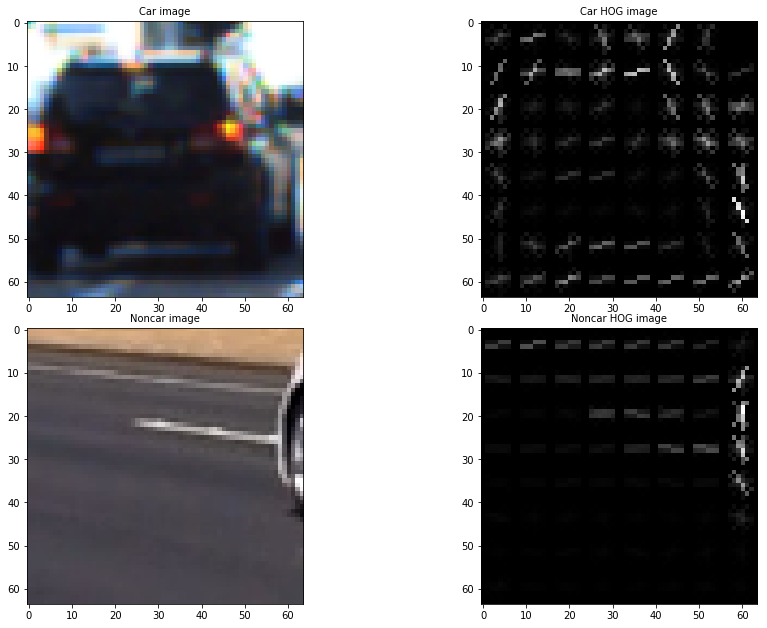

In [6]:
# Generate a random index to look at a car image
car_ind = np.random.randint(0, len(car_images))
noncar_ind = np.random.randint(0, len(noncar_images))
# Read in the image
car_image = mpimg.imread(car_images[car_ind])
noncar_image = mpimg.imread(noncar_images[noncar_ind])
car_gray = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY)
noncar_gray = cv2.cvtColor(noncar_image, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
car_features, car_hog_image = get_hog_features(car_gray, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)
noncar_features, noncar_hog_image = get_hog_features(noncar_gray, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)


f, ax = plt.subplots(2, 2, figsize=(12, 9))
f.tight_layout()
ax[0,0].imshow(car_image)
ax[0,0].set_title('Car image', fontsize=10)
ax[0,1].imshow(car_hog_image,cmap='gray')
ax[0,1].set_title('Car HOG image', fontsize=10)
ax[1,0].imshow(noncar_image)
ax[1,0].set_title('Noncar image', fontsize=10)
ax[1,1].imshow(noncar_hog_image,cmap='gray')
ax[1,1].set_title('Noncar HOG image', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



#### Train the linear SVM classifier

In [7]:
# Set the parameters for the feature extraction function

colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
t=time.time()
car_features = extract_features(car_images, color_space=colorspace, orient=orient, spatial_size=(32, 32),
                        hist_bins=32,pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,spatial_feat= True,hist_feat=True)
notcar_features = extract_features(noncar_images, color_space=colorspace, orient=orient, spatial_size=(32, 32),
                        hist_bins=32, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,spatial_feat= True,hist_feat=True)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC(C=0.0001)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
print(round(t-t2, 2), 'Seconds to train SVC...')
pickle.dump(svc, open('Classifier.p', 'wb'))

123.94 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
5.66 Seconds to train SVC...


### Test the classifier with test data

In [8]:
# Load the trained model

svc = pickle.load(open('Classifier.p', 'rb'))

t2 = time.time()

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Test Accuracy of SVC =  0.9823
My SVC predicts:  [ 0.  1.  1.  0.  1.  0.  1.  0.  0.  1.]
For these 10 labels:  [ 0.  1.  1.  0.  1.  0.  1.  0.  0.  1.]
0.0015 Seconds to predict 10 labels with SVC


In [10]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    rectangles = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return rectangles
    

In [11]:

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


### Experiment on the scale value and search region

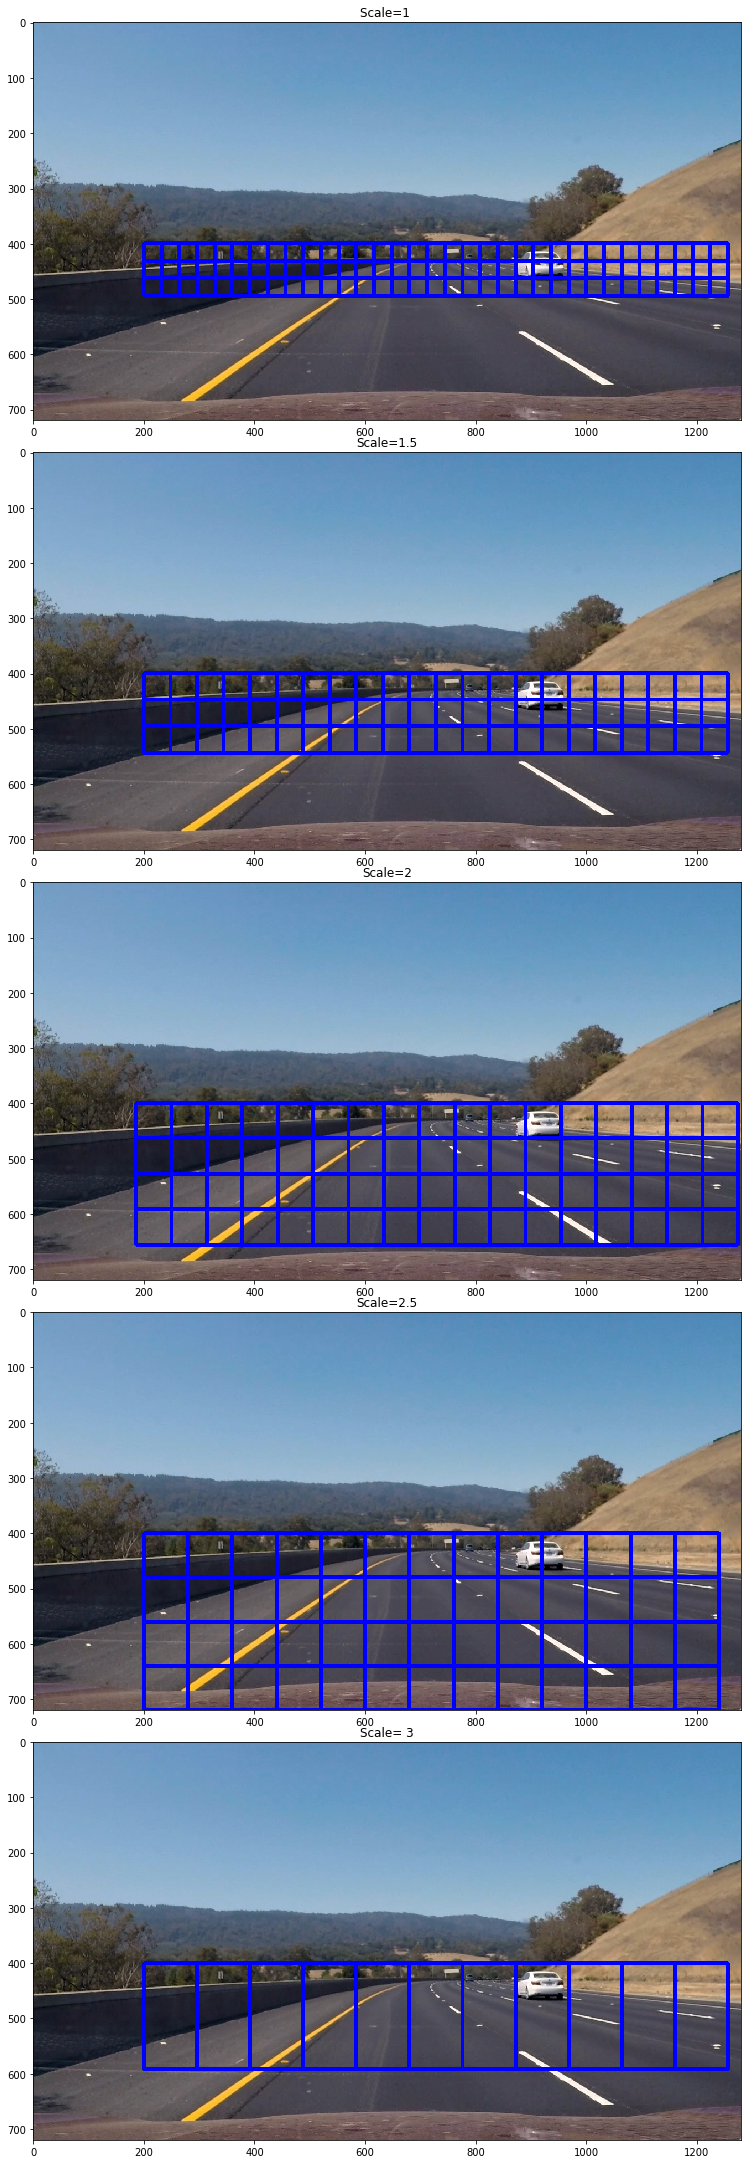

In [12]:
test_images=glob.glob('test_images/test*.jpg')
image0=mpimg.imread(test_images[2])
#Scale=1
windows0 = slide_window(image0, x_start_stop=[200, None], y_start_stop=[400, 520], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))
                       
window_img0 = draw_boxes(image0, windows0, color=(0, 0, 255), thick=6)                    

f, (ax0, ax1,ax2,ax3,ax4) = plt.subplots(5, 1, figsize=(30, 30))
f.tight_layout()
ax0.imshow(window_img0)
ax0.set_title('Scale=1 ', fontsize=12)
#Scale=1.5
windows0 = slide_window(image0, x_start_stop=[200, None], y_start_stop=[400, 550], 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))
                       
window_img0 = draw_boxes(image0, windows0, color=(0, 0, 255), thick=6) 
ax1.imshow(window_img0)
ax1.set_title('Scale=1.5', fontsize=12)  
#Scale=2
windows0 = slide_window(image0, x_start_stop=[186, None], y_start_stop=[400, 700], 
                    xy_window=(128,128), xy_overlap=(0.5, 0.5))
                       
window_img0 = draw_boxes(image0, windows0, color=(0, 0, 255), thick=6) 
ax2.imshow(window_img0)
ax2.set_title('Scale=2', fontsize=12)
#Scale=2.5
windows0 = slide_window(image0, x_start_stop=[200, None], y_start_stop=[400, None], 
                    xy_window=(160,160), xy_overlap=(0.5, 0.5))
                       
window_img0 = draw_boxes(image0, windows0, color=(0, 0, 255), thick=6) 
ax3.imshow(window_img0)
ax3.set_title('Scale=2.5', fontsize=12)
windows0 = slide_window(image0, x_start_stop=[200, None], y_start_stop=[400, 650], 
                    xy_window=(192,192), xy_overlap=(0.5, 0.5))
#Scale=3                       
window_img0 = draw_boxes(image0, windows0, color=(0, 0, 255), thick=6) 
ax4.imshow(window_img0)
ax4.set_title('Scale= 3', fontsize=12) 


In [13]:
#fixed parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
colorspace='YCrCb' 

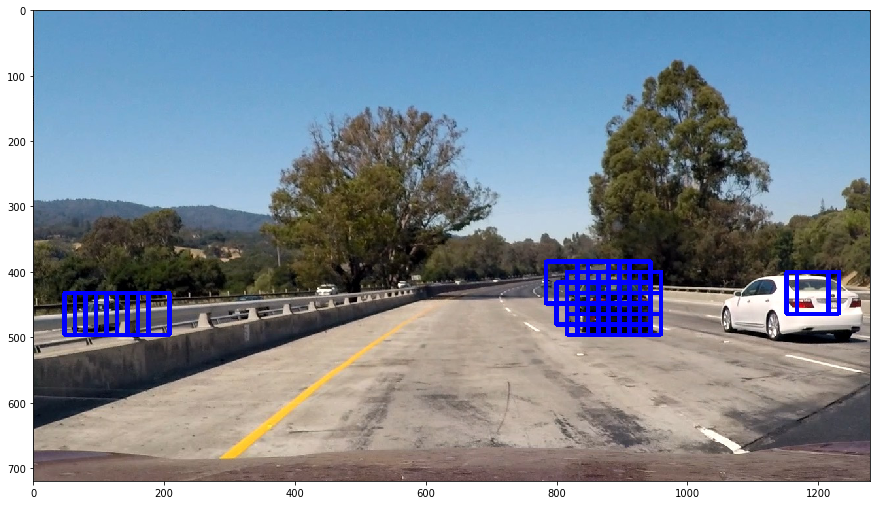

In [15]:
#Scale=1
test_images=glob.glob('test_images/test*.jpg')
img=mpimg.imread(test_images[0])
rect=[]
ystart = 384
ystop = 510
scale =1
rect.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,(32,32), 32))
#imcopy=draw_boxes(img, rectangles, color=(0, 0, 255), thick=6)
rectangles = [item for sublist in rect for item in sublist] 
imcopy=draw_boxes(img, rectangles, color=(0, 0, 255), thick=6)
plt.figure(figsize=(15,10))
plt.imshow(imcopy)

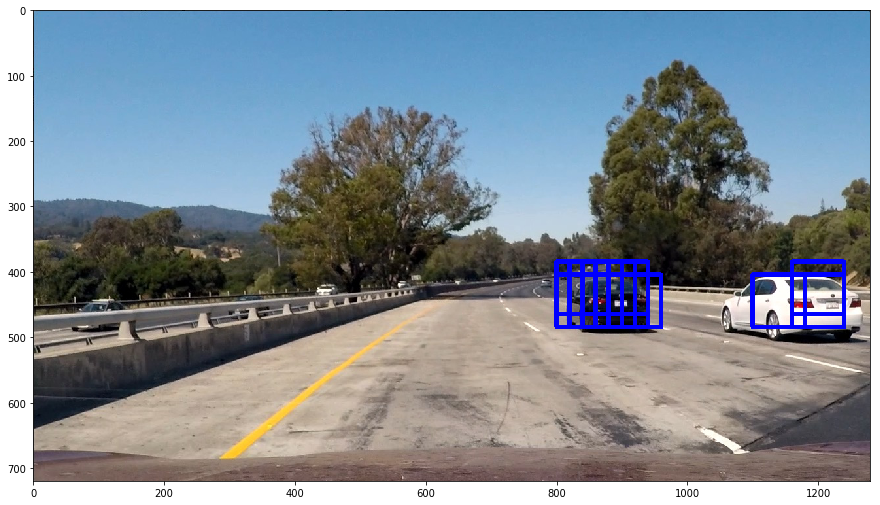

In [16]:
#Scale=1.25
img=mpimg.imread(test_images[0])
rect=[]
ystart = 384
ystop = 500
scale =1.25
rect.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,(32,32), 32))
#imcopy=draw_boxes(img, rectangles, color=(0, 0, 255), thick=6)
rectangles = [item for sublist in rect for item in sublist] 
imcopy=draw_boxes(img, rectangles, color=(0, 0, 255), thick=6)
plt.figure(figsize=(15,10))
plt.imshow(imcopy)

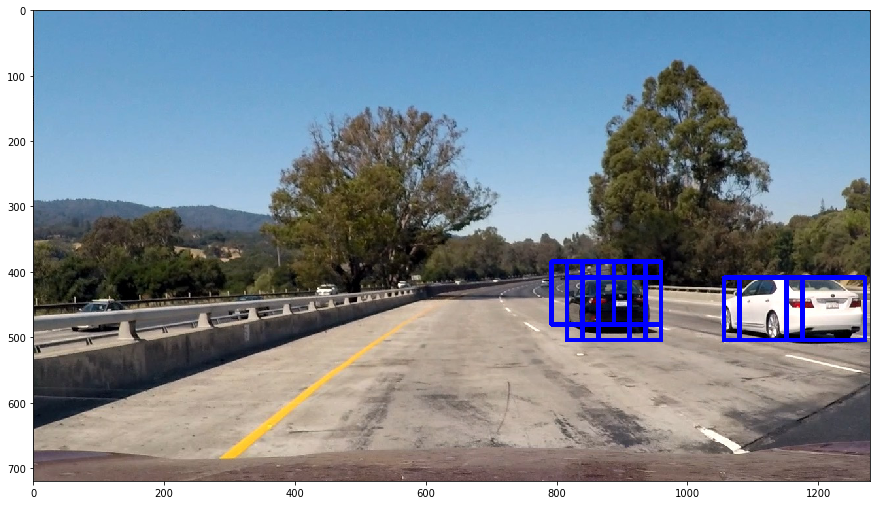

In [17]:
#Scale=1.5
img=mpimg.imread(test_images[0])
rect=[]
ystart = 384
ystop = 520
scale =1.5
rect.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,(32,32), 32))
rectangles = [item for sublist in rect for item in sublist] 
imcopy=draw_boxes(img, rectangles, color=(0, 0, 255), thick=6)
plt.figure(figsize=(15,10))
plt.imshow(imcopy)

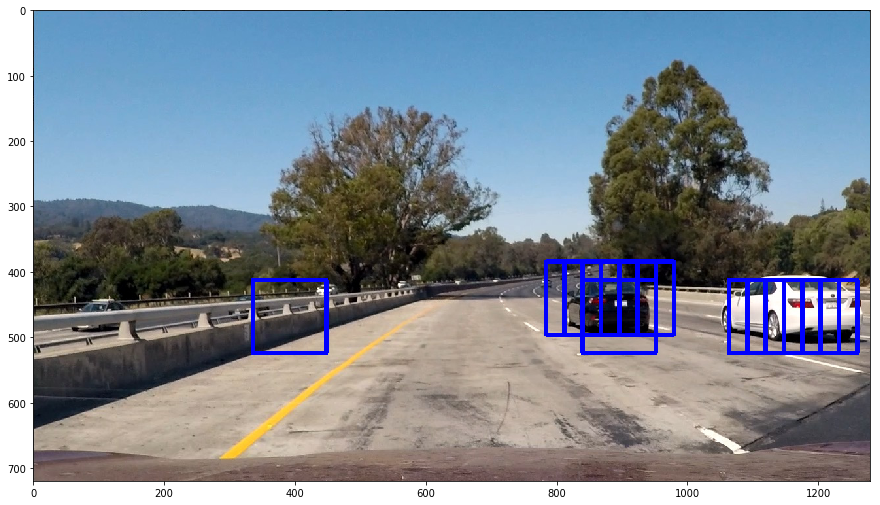

In [18]:
#Scale=1.75
img=mpimg.imread(test_images[0])
rect=[]
ystart = 384
ystop = 550
scale =1.75
rect.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,(32,32), 32))

rectangles = [item for sublist in rect for item in sublist] 
imcopy=draw_boxes(img, rectangles, color=(0, 0, 255), thick=6)
plt.figure(figsize=(15,10))
plt.imshow(imcopy)

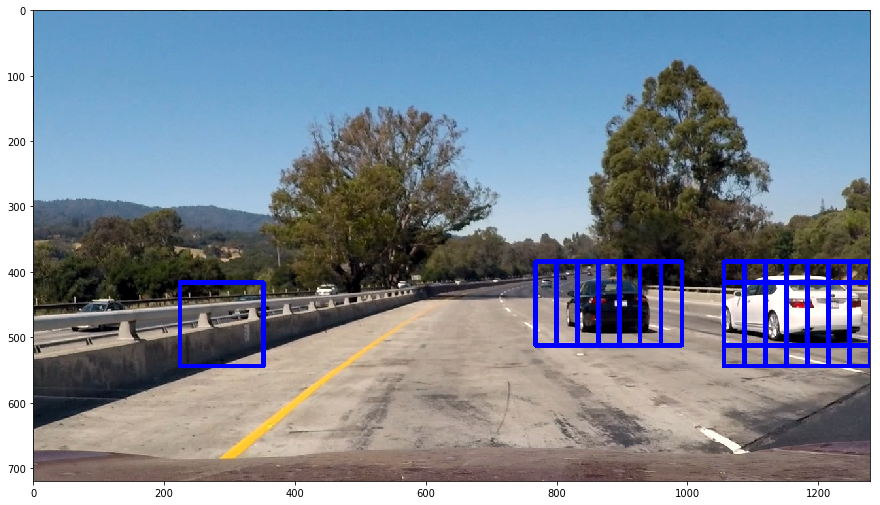

In [19]:
#Scale=2
img=mpimg.imread(test_images[0])
rect=[]
ystart = 384
ystop = 580
scale =2
rect.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,(32,32), 32))
#imcopy=draw_boxes(img, rectangles, color=(0, 0, 255), thick=6)
rectangles = [item for sublist in rect for item in sublist] 
imcopy=draw_boxes(img, rectangles, color=(0, 0, 255), thick=6)
plt.figure(figsize=(15,10))
plt.imshow(imcopy)

### Combine all the scan scales and process a single image

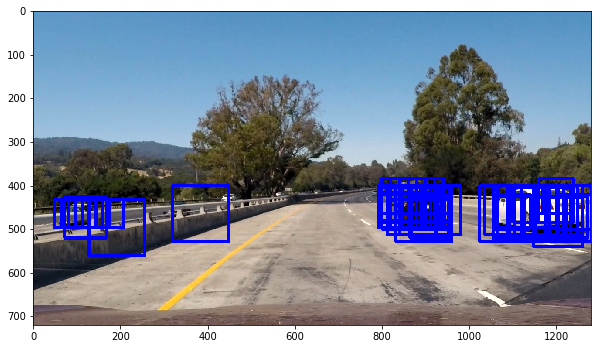

In [31]:
img=mpimg.imread(test_images[0])
rectangles = []
rect=[]
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"


ystart = 400
ystop = 510
scale =1
rect.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,(32,32), 32))

ystart = 384
ystop = 500
scale =1.25
rect.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,(32,32), 32))

ystart = 400
ystop = 500
scale =1.25
rect.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,(32,32), 32))

ystart = 400
ystop = 520
scale =1.5
rect.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,(32,32), 32))

ystart = 400
ystop = 550
scale =1.75
rect.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,(32,32), 32))

ystart = 400
ystop = 650
scale =2
rect.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,(32,32), 32))

# apparently this is the best way to flatten a list of lists
rectangles = [item for sublist in rect for item in sublist] 
test_img_rects = draw_boxes(img, rectangles, color=(0,0,255), thick=6)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

### Apply heat map to filter false positives

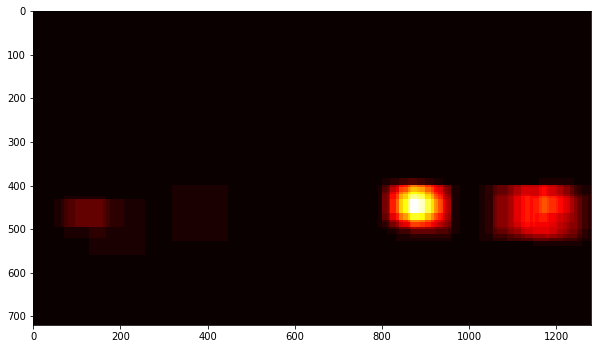

In [32]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
test_img=mpimg.imread(test_images[0])    
heatmap = np.zeros_like(test_img[:,:,0]).astype(np.float)
heatmap_img = add_heat(heatmap, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

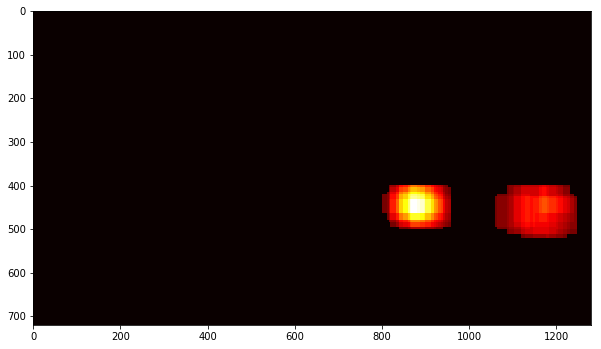

In [35]:
# Apply threshold
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

heatmap_img = apply_threshold(heatmap_img,5)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

2 cars found


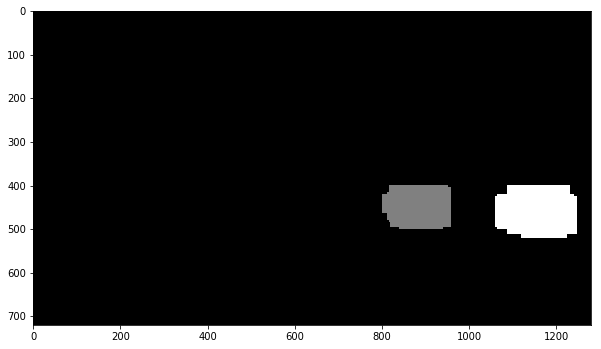

In [36]:
from scipy.ndimage.measurements import label
labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

In [37]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rectangles=[]
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        #Abadon the box which has a size smaller than 50 pix   
        if ((np.max(nonzerox)-np.min(nonzerox))>50 and (np.max(nonzeroy)-np.min(nonzeroy))>50):
                                 
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
            rectangles.append(bbox)
    # Return the image
    return img


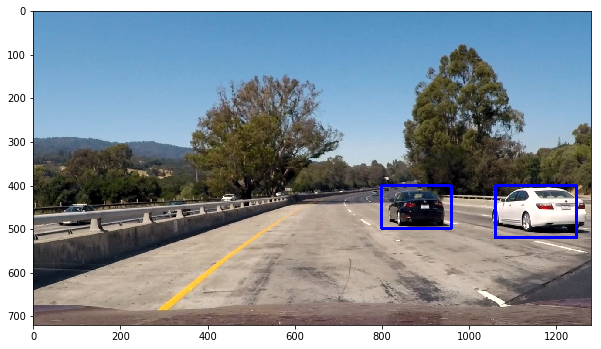

In [38]:
draw_img = draw_labeled_bboxes(np.copy(img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

### A pipeline to process a single image

In [39]:

def process_image(img):
    rect=[]
    rectangles = []
    colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

    ystart = 400
    ystop = 510
    scale =1
    rect.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,(32,32), 32))



    ystart = 384
    ystop = 500
    scale =1.25
    rect.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,(32,32), 32))
    
    ystart = 400
    ystop = 500
    scale =1.25
    rect.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,(32,32), 32))


    ystart = 400
    ystop = 520
    scale =1.5
    rect.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,(32,32), 32))



    ystart = 400
    ystop = 550
    scale =1.75
    rect.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,(32,32), 32))



    ystart = 400
    ystop = 650
    scale =2
    rect.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,(32,32), 32))

    # apparently this is the best way to flatten a list of lists
    rectangles = [item for sublist in rect for item in sublist] 

    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    #heatmap_img=remove_false_nagative(heatmap_img)
    #Remove the false negative detections of the vehicle driving on the opposite direction on the left
    heatmap_img[:,0:250]=0
    heatmap_img = apply_threshold(heatmap_img, 5)
    labels = label(heatmap_img)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img, heatmap_img

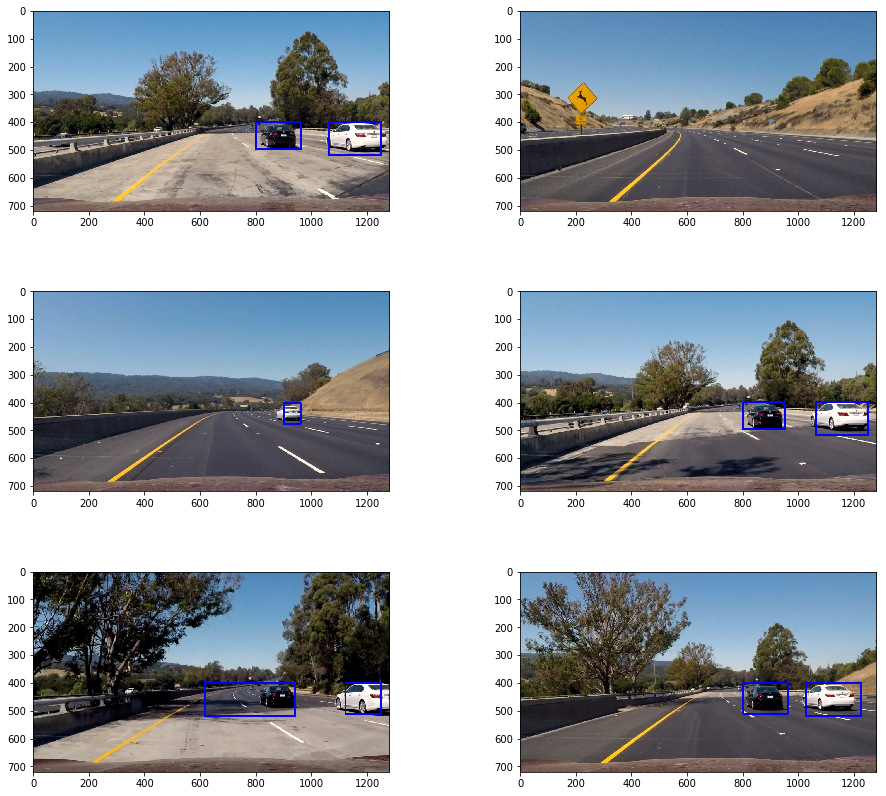

In [41]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .4, wspace=.2)
axs = axs.ravel()
drawing0,heatmap_img0=process_image(mpimg.imread(test_images[0]))
drawing1,heatmap_img1=process_image(mpimg.imread(test_images[1]))
drawing2,heatmap_img2=process_image(mpimg.imread(test_images[2]))
drawing3,heatmap_img3=process_image(mpimg.imread(test_images[3]))
drawing4,heatmap_img4=process_image(mpimg.imread(test_images[4]))
drawing5,heatmap_imgs5=process_image(mpimg.imread(test_images[5]))

axs[0].imshow(drawing0)
axs[1].imshow(drawing1)
axs[2].imshow(drawing2)
axs[3].imshow(drawing3)
axs[4].imshow(drawing4)
axs[5].imshow(drawing5)


In [42]:
#Video piepline
def image_process_for_video(img):
    image,heatmap_img=process_image(img)
    return image

In [43]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_output = 'test_video_output.mp4'
video_input1 = VideoFileClip('test_video.mp4')
processed_video = video_input1.fl_image(image_process_for_video)
%time processed_video.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [01:42<00:02,  2.58s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

Wall time: 1min 42s


### Improve the vehicle detection accuracy and robustness
The above result of the detction has several false positives. In order to eliminate that, the following actions are to be taken:
1. add the heatmap of 8 consecutive frames and apply a threshold on the final heatmap; because the false positives are not always at the same location which the correct detections are usually at the same spot;
2. narrow the detection region to prevent the detection of vehicle driving on the opposite direction.

A class is defined to store the heatmaps from the previous frames.

In [45]:
# Define a class to store the heatmap of images from video
from collections import deque
class Vehicle_Detect():
    def __init__(self):
        # history of rectangles previous 8 frames
        self.history_heatmap = deque(maxlen=8)
    #define a function to remove the false negative detections on the left
    def remove_false_nagative(self, img):
        img[:,0:200]=0
        return img
    #def add_heatmap(self, heatmap_img):
    #    self.history_heatmap.append(heatmap_img)
    def image_process_for_video_improved(self,img):
                  
        rect=[]
        rectangles = []
        colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
        orient = 9
        pix_per_cell = 8
        cell_per_block = 2
        hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

        ystart = 400
        ystop = 510
        scale =1
        rect.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,(32,32), 32))

        
        ystart = 384 
        ystop = 500
        scale =1.25
        rect.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,(32,32), 32))
        ystart = 400
        ystop = 500
        scale =1.25
        rect.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,(32,32), 32))

        ystart = 400
        ystop = 520
        scale =1.5
        rect.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,(32,32), 32))

        ystart = 400
        ystop = 550
        scale =1.75
        rect.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,(32,32), 32))

        ystart = 400
        ystop = 650
        scale =2
        rect.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,(32,32), 32))

        # apparently this is the best way to flatten a list of lists
        rectangles = [item for sublist in rect for item in sublist] 

        heatmap_img = np.zeros_like(img[:,:,0])
        heatmap_img = add_heat(heatmap_img, rectangles)
        #heatmap_img=self.remove_false_nagative(heatmap_img)
        heatmap_img[:,0:450]=0
        heatmap_img = apply_threshold(heatmap_img, 3)
        self.history_heatmap.append(heatmap_img)
        heatmap_final=np.sum(self.history_heatmap,axis=0)
            
        heatmap_final = apply_threshold(heatmap_final, 55)
        labels = label(heatmap_final)
        draw_img = draw_labeled_bboxes(np.copy(img), labels)

        return draw_img  


In [46]:
det = Vehicle_Detect()
video_output1 = 'test_video_output1.mp4'
video_input1 = VideoFileClip('test_video.mp4')
processed_video = video_input1.fl_image(det.image_process_for_video_improved)
%time processed_video.write_videofile(video_output1, audio=False)
video_input1.reader.close()


[MoviePy] >>>> Building video test_video_output1.mp4
[MoviePy] Writing video test_video_output1.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [01:40<00:02,  2.66s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output1.mp4 

Wall time: 1min 40s


In [48]:
det = Vehicle_Detect()
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')
processed_video = video_input1.fl_image(det.image_process_for_video_improved)
%time processed_video.write_videofile(video_output1, audio=False)
video_input1.reader.close()


[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [51:21<00:02,  2.40s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 51min 22s
